In [ ]:
# Uncomment and run this when using colab.
#%pip install pygeoinf

# Tutorial 5 - Gaussian measures

A Gaussian measure on a Hilbert space, $X$, generalises the familar Gaussian distribution on finite-dimensionsl Euclidean spaces. Such a measure, $\mu$, is characterised by its **expectation**, this being an element of $X$, and its **covariance** which is a self-adjoint and trace-class linear operator on $X$. We use the notation $\mathcal{N}_{X}(\overline{u}, Q)$ to denote a Gaussian measure on $X$ with expectation $\overline{u} \in X$ and covariance $Q \in \mathrm{Hom}(X)$. If an $X$-valued random variable has probability law $\mu$ then we write $u \sim \mu$. Note that within this discussion the terms "probability measure" and "probability distribition" are used interchangably, with the prefix "probability" typically being dropped. 

Within ```pygeoinf``` Gaussian measures are implemented withint the ```GaussianMeasure``` class. This class stores the measure's expectation and covariance while also providing a range of useful methods.

### Constructing a Gaussian measure

A instance of ```GaussianMeasure``` can be constructed by provide either of the following keyword arguments: 

- ```covariance```: The covariance, $Q$, as an instance of ```LinearOperator```. 
- ```covariance_factor```:  A Cholesky factor, $L$, for the covariance such that $Q = LL^{*}$. The factor $L$ is given as a ```LinearOperator``` from a Euclidean space into the domain of the measure. 

A range of other keyword arguments can be provided:

- ```expectation```: The expected value for the measure. The default is ```None``` in which case the measure has zero expectation. 
- ```sample```: A callable object that takes no arguments and returns sample from the measure. The default is ```None```. 
- ```inverse_covariance```: The inverse of the covariance as a ```LinearOperator```. The default is ```None```.
- ```inverse_covariance_factor```: The inverse of the covariance factor. The default is ```None```. 

If the covariance factor, $L \in \mathrm{Hom}(\mathbb{R}^{n},X)$, samples from the measure can be efficiently generated in the form
$$
u = \overline{u} + L w, 
$$
where $w \sim \mathcal{N}_{\mathbb{R}^{n}}(0, \mathrm{Id}_{\mathbb{R}^{n}})$. This approach takes precedence over any user provided sampling method. 

As a first example, we construct a ```GaussianMeasure``` defined on ```EuclideanSpace``` by setting its covariance and expectation. Because no ```sample``` method has been provided, it is not possible to generate samples from the measure. Note that in constructing the covariance we first set it as a numpy matrix and then form a ```LinearOperator``` using the static method ```self_adjoint_from_matrix```. 

In [ ]:
import numpy as np
import pygeoinf as inf

# Set the space.
X = inf.EuclideanSpace(5)

# Set the expectation
expectation = np.random.randn(X.dim)

# Generate a covariance matrix
matrix = np.random.randn(X.dim, X.dim)
covariance_matrix = matrix @ matrix.T
covariance = inf.LinearOperator.self_adjoint_from_matrix(X, covariance_matrix)

# Set the GaussianMeasure
mu = inf.GaussianMeasure(covariance=covariance, expectation=expectation)


Such a ```GaussianMeasure``` has relatively little functionality. But its basic data can be accessed:

In [3]:
print(f'mu.domain == X is: {mu.domain == X}')
print(f'Expectation of the measure: {mu.expectation}')
print(f'Covariance of the measure:\n {mu.covariance}')

mu.domain == X is: True
Expectation of the measure: [-2.13387249  1.05452966 -0.4895571  -0.12320256 -2.28852682]
Covariance of the measure:
 [[ 4.36542174 -3.8281961   2.5959916   1.39553136  0.12261482]
 [-3.8281961   8.71414564 -4.29632035 -4.09510053 -2.5154239 ]
 [ 2.5959916  -4.29632035  7.92081567  4.89046507  2.06106245]
 [ 1.39553136 -4.09510053  4.89046507  5.65539397  3.0967805 ]
 [ 0.12261482 -2.5154239   2.06106245  3.0967805   1.98655637]]


Let's redefine this measure using the same expectation and covariance, but now providing a sampling method via ```scipy.stats```

In [ ]:
from scipy.stats import  multivariate_normal

# Set up the scipy multivariate normal.
distribution = multivariate_normal(mean = expectation, cov = covariance_matrix)

# Now set the Gassian measure including a sampling method.
mu = (inf.GaussianMeasure(
        covariance=covariance,
        expectation=expectation,
        sample=lambda : distribution.rvs())
    )

Using this new measure, we can generate random samples using ```sample``` for a single sample or ```samples``` for multiple samples returned as a list:

In [ ]:
# Print a single sample.
print(f'A sample from the measure:\n {mu.sample()}')

# Get a list of ten samples and print them
print(f'A set of samples from the measure:')
samples = mu.samples(10)
for i, sample in enumerate(samples):
    print(f'{sample}')


A sample from the measure:
 [-2.83213967  1.3794842   5.35629402  2.73414098 -1.12108835]
A set of samples from the measure:
[-4.89486727  0.8513005  -2.80412416 -2.96792231 -2.97120038]
[-5.40080886  5.28102343  3.3033801   1.81020631 -1.56197556]
[-5.33881723  1.35215965 -1.09497868  2.85480755  0.25484973]
[-2.7398364   1.69939913 -1.59032393  0.16643849 -1.6375867 ]
[ 1.49410569 -2.50987764  0.26458292 -1.77981447 -3.57248941]
[-4.27365022  6.39248798 -1.97287701 -1.301961   -3.09750566]
[-4.072466    0.73838649 -0.17696682  1.88532247 -0.65765377]
[-3.52058179  1.53102825 -3.72712101 -3.72823573 -3.78186227]
[ 1.11487308 -0.41214792 -0.4632472  -0.65734788 -3.10128457]
[-1.46206092  1.38046778  0.18549934 -0.00622371 -2.43730967]


A static method, ```from_covariance_matrix``` is provided that can simplify the construction of simple Gaussian measures. Internally, the eigen-decomposition of the covariance matrix is formed and used to factor both the covariance and inverse covariance. Note that the matrix input is the Galerkin representation of the covariance. Because this method is based on the storage and factorisation of dense matrices it is inefficient in high-dimensional spaces. 

In [ ]:
# Form from using the static method.
mu = inf.GaussianMeasure.from_covariance_matrix(X, covariance_matrix, expectation=expectation)

print(f'Expectation of the measure: {mu.expectation}')
print(f'Covariance of the measure:\n {mu.covariance}')

# The sampling method is now set for us.
samples = mu.samples(10)
for i, sample in enumerate(samples):
    print(f'sample {i} is equal to: {sample}')


Expectation of the measure: [-2.13387249  1.05452966 -0.4895571  -0.12320256 -2.28852682]
Covariance of the measure:
 [[ 4.36542174 -3.8281961   2.5959916   1.39553136  0.12261482]
 [-3.8281961   8.71414564 -4.29632035 -4.09510053 -2.5154239 ]
 [ 2.5959916  -4.29632035  7.92081567  4.89046507  2.06106245]
 [ 1.39553136 -4.09510053  4.89046507  5.65539397  3.0967805 ]
 [ 0.12261482 -2.5154239   2.06106245  3.0967805   1.98655637]]
sample 0 is equal to: [-1.67426433 -0.27788624  1.48760151  1.63015211 -1.40841251]
sample 1 is equal to: [-5.41770475  1.47604046 -0.82626312  0.34554376 -1.1975025 ]
sample 2 is equal to: [-4.33960019  3.74393669 -0.44700056 -0.66634967 -2.39131497]
sample 3 is equal to: [-1.12589981  0.51669207  1.80888457  0.43965869 -2.4973457 ]
sample 4 is equal to: [-1.97022831 -1.14869163 -2.1353192   0.56756502 -1.33651498]
sample 5 is equal to: [-2.44199193  4.22517285 -3.01478179 -1.12668123 -3.28617349]
sample 6 is equal to: [-2.03280231  3.79382897 -4.78224657 -2.

### Other static methods for constructing Gaussian measures

In addition to ```from_covariance_matrix``` a several other static methods are provided for constructing common Gaussian measures. In each case an efficient sampling method is provided. 

The method ```from_standard_deviation``` returns a Gaussian measure on $X$ whose covariance takes the form
$$
Q = \sigma^{2}\,\mathrm{Id}_{X}, 
$$
with $\sigma$ the standard deviation and $\mathrm{Id}_{X}$ the identity operator on $X$. Due to the trace-class condition, this measure is only well-defined on finite-dimensional spaces. The expectation of the measure can optionally be set, with the default being zero. 

A related method is ```from_standard_deviations```. In this casem it is assumed that the Galerkin representation of the covariance is diagonal and hence only its diagonal values need to be provided. Again a non-zero expectation can be optionally set. 

A final method to mention for the timebeing is ```from_samples```. In this case, the user provides the domain for the measure along with a collection of its elements, $\{x_{i}\}_{i=1}^{n}$ with $n >1$. A measure is then constructed whose expectation is equal to the **sample expectation**
$$
\overline{x} = \frac{1}{n}\sum_{i=1}^{n}x_{i}, 
$$
and whose covariance is is equal to the **sample covariance**
$$
Q = \frac{1}{n-1}\sum_{i=1}^{n}(x_{i}-\overline{x})\otimes (x_{i}-\overline{x}), 
$$
with $\otimes$ denoting the tensor product. In this case, samples from the measure can be generated in the form
$$
x = \overline{x} + \frac{1}{\sqrt{n-1}}\sum_{i=1}^{n} w_{i} \,(x_{i}-\overline{x})
$$
where the $w_{i}\in \mathbb{R}$ are drawn from the standard Gaussian distribution.

### Transformations of Gaussian measures

Gaussian measures can be transformed in various ways. In particular, the push-forward of a Gaussian measure under an affine mapping remains Gaussian. Let $\mu = \mathcal{N}_{X}(\overline{u},Q)$ and consider the affine mapping
$$
f(v) = v_{0} + A u,
$$
for $A \in \mathrm{Hom}(X,Y)$. It can then be shown that 
$$
f_{*}\mu = \mathcal{N}_{Y}(v_{0} + A \overline{u}, AQA^{*}).
$$
This idea is implemented in ```GaussianMeasure``` through the ```affine_mapping``` method:

In [ ]:
# Set the codomain of the transformation
Y = inf.EuclideanSpace(3)

# Set the translation
y0 = Y.random()

# Set the operator to be the projection from X to Y.
A = inf.LinearOperator(X, Y, lambda x : x[:Y.dim])

# Push forward the measure mu.
nu = mu.affine_mapping(translation=y0, operator=A)


# Print the mean and covariance.
print(f'Expectation of the measure: {nu.expectation}')
print(f'Covariance of the measure:\n {nu.covariance}')

# The new measure has a sampling method so long as the original does:
samples = nu.samples(10)
for i, sample in enumerate(samples):
    print(f'sample {i} is equal to: {sample}')


# If the original measure is in factored form, so is the new one.
print(nu.covariance_factor_set)

# But the inverse of the covariance is not set.
print(nu.inverse_covariance_set)

Expectation of the measure: [-2.9109628   0.94060056 -2.2468168 ]
Covariance of the measure:
 [[ 4.36542174 -3.8281961   2.5959916 ]
 [-3.8281961   8.71414564 -4.29632035]
 [ 2.5959916  -4.29632035  7.92081567]]
sample 0 is equal to: [ 0.65855633 -1.7095042   2.97158402]
sample 1 is equal to: [-3.60757632  1.73906337 -0.63265479]
sample 2 is equal to: [-5.5504044   3.02193252 -5.20155178]
sample 3 is equal to: [ 0.26155417 -0.23947034 -0.31069359]
sample 4 is equal to: [-3.74401911 -1.3263118  -2.31544357]
sample 5 is equal to: [-5.13077415  2.17805543 -5.801635  ]
sample 6 is equal to: [-2.66361449  3.0526353  -2.90015286]
sample 7 is equal to: [-1.03715873  3.04391333 -3.10004029]
sample 8 is equal to: [-5.91596402  7.7175197  -8.82452479]
sample 9 is equal to: [-1.33215631 -1.20627763  0.06215464]
True
False


As special cases of the affine transformation, other algebraic operations with measures can be performed. For example:

In [8]:
pi = 2 * mu
print(f'Expectation of the measure: {pi.expectation}')
print(f'Covariance of the measure:\n {pi.covariance}')

xi = mu + pi
print(f'Expectation of the measure: {pi.expectation}')
print(f'Covariance of the measure:\n {pi.covariance}')

Expectation of the measure: [-4.26774499  2.10905931 -0.97911419 -0.24640512 -4.57705364]
Covariance of the measure:
 [[ 17.46168698 -15.31278439  10.38396641   5.58212543   0.49045926]
 [-15.31278439  34.85658258 -17.1852814  -16.38040213 -10.06169562]
 [ 10.38396641 -17.1852814   31.68326267  19.56186027   8.24424982]
 [  5.58212543 -16.38040213  19.56186027  22.62157589  12.387122  ]
 [  0.49045926 -10.06169562   8.24424982  12.387122     7.94622547]]
Expectation of the measure: [-4.26774499  2.10905931 -0.97911419 -0.24640512 -4.57705364]
Covariance of the measure:
 [[ 17.46168698 -15.31278439  10.38396641   5.58212543   0.49045926]
 [-15.31278439  34.85658258 -17.1852814  -16.38040213 -10.06169562]
 [ 10.38396641 -17.1852814   31.68326267  19.56186027   8.24424982]
 [  5.58212543 -16.38040213  19.56186027  22.62157589  12.387122  ]
 [  0.49045926 -10.06169562   8.24424982  12.387122     7.94622547]]


### Gaussian measures on function spaces

So far we have considered Gaussian measures defined on Euclidean spaces. But all the ideas carry over to function spaces. Looking, as usual, at the case of $H^{s}(\mathbb{S}^{1})$ the class ```Sobolev``` in ```pygeoinf.symmetric_space.circle``` provides methods for generating a number of useful ```GaussianMeasures```. All these measures have in common invariance under the domains underlying symmetry group which, in this case, is $\mathrm{SO}(1)$. It can be shown that the covariance for such a measure takes the form $f(\Delta)$ with $f$ a function that decreases sufficient fast and $\Delta$ the Laplacian. A method ```invariant_gaussian_measure``` is provided that can generate such a meaure given the function, $f$. This is then used to generate measures for two conventional choices of $f$. The first is ```sobolev_gaussian_measure``` whose covariance is given by 
$$
Q = \alpha (1 + \lambda^{2}\Delta)^{-s}, 
$$
with $\alpha$, $\lambda$ and $s$ being parameters.  The second is ```heat_gaussian_measure``` whose covariance is given by 
$$
Q = \alpha \mathrm{e}^{-\lambda^{2}\Delta}, 
$$
with $\alpha$ and $\lambda$ being parameters. In either case the value of $\alpha$ is implicitly set by specifying an ```amplitude``` which is equal to the pointwise standard deviation for random fields generated from the measure. 

In the code below we set up ```heat_gaussian_measure`` and plot a set of samples. 

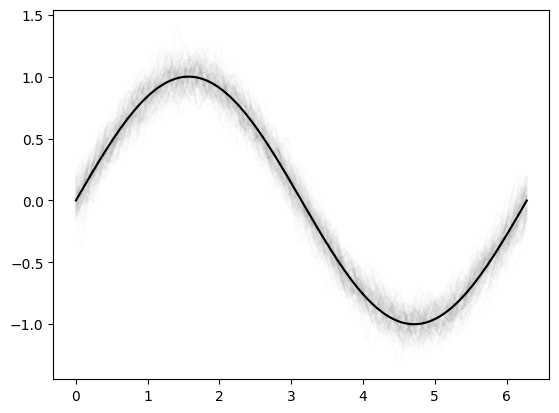

In [9]:
import matplotlib.pyplot as plt
from pygeoinf.symmetric_space.circle import Sobolev

X = Sobolev.from_sobolev_parameters(2,0.01)

u = X.project_function(lambda th : np.sin(th))

mu = X.heat_gaussian_measure(0.05, 0.1, expectation=u)

fig, ax = plt.subplots()
X.plot(mu.expectation, fig=fig, ax=ax, color = 'k')
number_of_samples = 100
samples = mu.samples(number_of_samples)
for sample in samples:
    X.plot(sample, fig=fig, ax=ax, color = 'k', alpha = 1/number_of_samples)

plt.show()

Just as in the finite-dimensional case, we can transform the measure under an affine mapping. Here we set up the derivative operator as in Tutorial 4 and use this to push forward our measure.

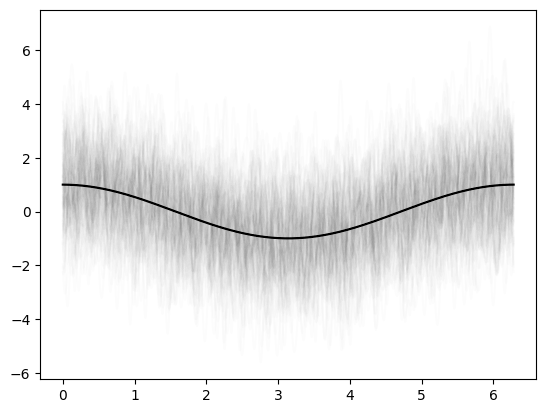

In [ ]:
Y = Sobolev.from_sobolev_parameters(1,0.01)

# Define the derivative mapping
def mapping(u):
    coeff = X.to_coefficient(u)
    for k in range(coeff.size):
        coeff[k] *= 1j * k
    return Y.from_coefficient(coeff)

# Define the formal adjoint. Note that this
# needs a separate definition because the two
# spaces have different spatial discretisations.
def formal_adjoint_mapping(v):
    coeff = Y.to_coefficient(v)
    for k in range(coeff.size):
        coeff[k] *= -1j * k
    return X.from_coefficient(coeff)


# Set up the operator.
A = inf.LinearOperator(X, Y, mapping, formal_adjoint_mapping=formal_adjoint_mapping)

nu = mu.affine_mapping(operator=A)

fig, ax = plt.subplots()
Y.plot(nu.expectation, fig=fig, ax=ax, color = 'k')
samples = nu.samples(number_of_samples)
for sample in samples:
    Y.plot(sample, fig=fig, ax=ax, color = 'k', alpha = 1/number_of_samples)

plt.show()